### Configure Environment

In [ ]:
from google.colab import drive
root = '/content/drive'
drive.mount(root)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U bitsandbytes
!pip install -U peft
!pip install -U transformers accelerate
!pip install evaluate rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
# ✅ Confirm install
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)

from datasets import load_from_disk
from huggingface_hub import login
import evaluate

import os

import pandas as pd
import re
import matplotlib.pyplot as plt

In [ ]:
os.environ['HF_TOKEN'] = '<REDACTED>'
login(token=os.environ["HF_TOKEN"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
recipe_nlg_data_path = f'{root}/MyDrive/NLP-266/Project/RecipeNLG'

dataset = load_from_disk(f'file://{recipe_nlg_data_path}/numbered_recipe_nlg_dataset')

### Helpers

In [ ]:
def get_reference_instruction_list(batch):
  return {
          "reference_instruction_list": [
              directions.split('", "')
              for directions in batch["directions"]
              ]
      }

def extract_new_tokens(example):
  return {"generated_clean": example['generated'].split("Your response:")[-1].strip()}

def get_generated_instruction_list(batch):
    text = batch["generated_clean"]

    instruction_starts = sorted([match.span() for match in re.finditer(r'(\[\d+\]|\d+\.)', text)])
    instructions = []

    for i, span in enumerate(instruction_starts):
        if i == len(instruction_starts) - 1:
            instruction = text[span[-1]:]
        else:
            instruction = text[span[-1]:instruction_starts[i+1][0]]
        instructions.append(instruction.strip())

    return {"generated_instruction_list": instructions}

### Get Teacher Generated Reasoning

In [ ]:
cot_names = ['CoT_Fine-Tuned_13b', 'CoT_Fine-Tuned_7b', 'CoT_Non-Fine-Tuned_13b_incomplete', 'CoT_Non-Fine-Tuned_7b']

cot_ft_13 = (
      load_from_disk(f'file://{recipe_nlg_data_path}'
                     f'/Generated_Data/Evaluations/{cot_names[0]}')
      .map(parse_comparison_evaluation)
      .map(extract_new_tokens)
      .map(get_generated_instruction_list)
      #.to_pandas()

  )

cot_ft_7 = (
      load_from_disk(f'file://{recipe_nlg_data_path}'
                     f'/Generated_Data/Evaluations/Non-Fine-Tuned_Non-Retrieval_0')
      .map(parse_comparison_evaluation)
      .map(extract_new_tokens)
      .map(get_generated_instruction_list)
      #.to_pandas()
  )

cot_nft_13 = (
      load_from_disk(f'file://{recipe_nlg_data_path}'
                     f'/Generated_Data/Evaluations/{cot_names[2]}')
      .map(parse_comparison_evaluation)
      .map(extract_new_tokens)
      .map(get_generated_instruction_list)
      #.to_pandas()
  )

cot_nft_7 = (
      load_from_disk(f'file://{recipe_nlg_data_path}'
                     f'/Generated_Data/Evaluations/{cot_names[3]}')
      .map(parse_comparison_evaluation)
      .map(extract_new_tokens)
      .map(get_generated_instruction_list)
      #.to_pandas()
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### Data Ingestion

In [ ]:
list_delim = '", "'

def form_direction_step_text(direction_list_str):
  # parse out parentheses
  direction_str = direction_list_str[1:-1]

  # split string
  str_list = direction_str.split(list_delim)

  # remove leading and trailing quotes
  str_list[0] = str_list[0][1:]
  str_list[-1] = str_list[-1][:-1]


  # number with consistent formatting [1], [2], ...
  s_list_num = [f'[{i+1}] {s}' for i, s in enumerate(str_list)]
  final_str = '\n'.join(s_list_num)

  return final_str

In [ ]:
train = train.map(lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})

Map:   0%|          | 0/349677 [00:00<?, ? examples/s]

In [ ]:
val = dataset['validation'].map(lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
test = dataset['test'].map(lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})
prompt = dataset['prompt'].map(lambda x: {'directions_formatted': form_direction_step_text(x['directions'])})

Map:   0%|          | 0/3670 [00:00<?, ? examples/s]

Map:   0%|          | 0/3671 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
from datasets import DatasetDict

new_dataset = DatasetDict({
    'train': train,
    'validation': val,
    'test': test,
    'prompt': prompt
})
new_dataset.save_to_disk(f'{recipe_nlg_data_path}/numbered_recipe_nlg_dataset')

Saving the dataset (0/2 shards):   0%|          | 0/349677 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3670 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3671 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

### Model Config

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_enable_fp32_cpu_offload=True
)

In [ ]:
model_id = "teknium/OpenHermes-2.5-Mistral-7B"
#model_id = "Qwen/Qwen2.5-14B-Instruct-1M"

tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    trust_remote_code=True,
    quantization_config=quantization_config,
    device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
def form_example(row):
    return f'''Recipe Title: {row['title']}
Ingredients: {row['ingredients']}
Your response:
'''

In [ ]:
TRAIN_SIZE = 1000
VAL_SIZE = 100

train = dataset['train'].shuffle().select(range(TRAIN_SIZE)).map(lambda x: {'prompt': form_example(x)})
val = dataset['validation'].shuffle().select(range(VAL_SIZE)).map(lambda x: {'prompt': form_example(x)})

### Form Teacher Model Training Data

In [ ]:
MAX_SEQUENCE_LENGTH = 256

def preprocess_generation_batch(batch, input_col="prompt", output_col="directions_formatted"):

    inputs_encoded = tokenizer.batch_encode_plus(
            batch[input_col],
            max_length=MAX_SEQUENCE_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

    outputs_encoded = tokenizer.batch_encode_plus(
        batch[output_col],
        max_length=MAX_SEQUENCE_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    return {'input_ids': inputs_encoded['input_ids'],
            'labels': outputs_encoded['input_ids']}

### Fine Tune

In [ ]:
from transformers import TrainingArguments, Trainer
from peft import LoraConfig, TaskType, get_peft_model
from transformers import Trainer # Import Trainer here as well for clarity

In [ ]:
BATCH_SIZE = 32
NUM_EPOCHS = 2
MAX_LAYERS = 32

In [ ]:
def is_target_module(name, numbered_layers):
    # Match q_proj or v_proj only in last 4 layers
    pattern = re.compile(r"model\.layers\.(\d+)\.self_attn\.(q_proj|v_proj)")
    match = pattern.fullmatch(name)
    if not match:
        return False
    layer_idx = int(match.group(1))
    return layer_idx in numbered_layers




def fine_tune(base_model, train_data, n_layers=4, n_epochs=2, save_path_rel=""):
  if not save_path_rel:
    raise ValueError("Save path must be provided")

  lora_config = LoraConfig(
      task_type=TaskType.CAUSAL_LM, # type of task to train on
      inference_mode=False, # set to False for training
      r=8, # dimension of the smaller matrices
      lora_alpha=16, # scaling factor
      lora_dropout=0.1  # dropout of LoRA layers
  )

  last_layers = list(range(MAX_LAYERS - n_layers, MAX_LAYERS))

  lora_config.target_modules = [
      name for name, _ in model.named_modules()
      if is_target_module(name, last_layers)
  ]

  model_peft = get_peft_model(model, lora_config)

  training_args = TrainingArguments(
        "recipe_generation_model",
         eval_strategy='epoch',
        logging_strategy='epoch',
        learning_rate=5e-5,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=n_epochs,
        report_to='none',
        label_names=['labels']
    )

  trainer = Trainer(
          model_peft,
          training_args,
          train_dataset=train_data,
          eval_dataset=val
      )

  trainer.train()
  model_peft.save_pretrained(f'{recipe_nlg_data_path}/{save_path_rel}')

32


#### Fine-Tune a Smaller Reasoning Generator [TODO]

In [ ]:
def remove_your_response(example):
  return {"prompt": example['prompt'].split('Your response:')[0]}

In [ ]:
train = train.map(remove_your_response)
train = train.map(preprocess_generation_batch, batched=True, fn_kwargs={"input_col": "prompt", "output_col": "reasoning"})

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
fine_tune(model, train, save_path_rel="13b_reasoning_model_from_teacher")

Step,Training Loss
125,21.223700
250,20.509800


#### Fine-Tune a Smaller Reasoning-Augmented Instruction Generator

In [ ]:
# Reset Training Data

train = load_from_disk(f'file://{recipe_nlg_data_path}/Generated_Data/big_model_train_reasoning')

In [ ]:
def add_reasoning_to_prompt(train_example):
  prompt_prefix = train_example['prompt']
  prompt = prompt_prefix + 'Reasoning: ' + train_example['reasoning'] + '\nYour response:'
  return {'prompt': prompt}

train = train.map(remove_your_response)
train = train.map(add_reasoning_to_prompt)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
train['prompt'][0]

'Recipe Title: Smoked Turkey Club\nIngredients: ["75 slices White or whole wheat bread slices, toasted", "1-1/2 cups KRAFT MAYO Real Mayonnaise", "- CARVING BOARD Turkey Bulk Hickory Smoked Skin On", "25 each large tomatoes, each cut into 5 slices King Sooper\'s 1 lb For $0.99 thru 02/09", "50 each leaf lettuce leaves", "50 slices KRAFT CHEDASHARP Pasteurized Process American Cheese Slice", "50 slices OSCAR MAYER Fast Prep Precooked Bacon"]\nReasoning: To prepare the Smoked Turkey Club sandwiches, let\'s break down the process:\n\n1. **Prepare the bacon**: Since it needs to be cooked, start with the OSCAR MAYER Fast Prep Precooked Bacon. Place the slices on a baking sheet and bake them in a preheated oven at around 400°F (200°C) until they reach your desired level of crispness. This should take about 8-10 minutes.\n\n2. **Slice the turkey**: While the bacon is cooking, slice the CARVING BOARD Turkey Bulk Hickory Smoked Skin On into thin pieces. Ensure you have enough slices to fill the

In [ ]:
train = train.map(preprocess_generation_batch, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
fine_tune(model, train, save_path_rel="13b_instruction_model_from_teacher")

In [ ]:
train = train.map(add_reasoning_to_prompt)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### Inference from Student Models

In [ ]:
MAX_SEQUENCE_LENGTH = 256

def preprocess_generation_batch_from_reason(batch):

    inputs_encoded = tokenizer.batch_encode_plus(
            batch["prompt"],
            max_length=MAX_SEQUENCE_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

    outputs_encoded = tokenizer.batch_encode_plus(
        batch["directions_formatted"],
        max_length=MAX_SEQUENCE_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    return {'input_ids': inputs_encoded['input_ids'],
            'labels': outputs_encoded['input_ids']}

In [ ]:
train = train.map(preprocess_generation_batch, batched=True)
#val = val.map(preprocess_generation_batch, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
train.save_to_disk(f'{recipe_nlg_data_path}/train_processed_1k')
val.save_to_disk(f'{recipe_nlg_data_path}/val_processed_100')

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
train = load_from_disk(f'file://{recipe_nlg_data_path}/train_processed_1k')
val = load_from_disk(f'file://{recipe_nlg_data_path}/val_processed_100')

In [ ]:
fine_tune(model, train, n_layers=4, n_epochs=10, save_path_rel="ignore_1k_10e_4l")

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,7.628600,6.779135
2,6.188700,5.986368
3,5.579400,5.559366
4,5.335200,5.334655
5,5.173800,5.243626
6,5.074300,5.120729
7,4.987000,5.043873
8,4.932400,5.001145
9,4.880400,4.960740
10,4.833200,4.950641


In [ ]:
fine_tune(model, train, n_layers=8, n_epochs=10, save_path_rel="ignore_1k_10e_8l")

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,7.275300,6.442850
2,5.929100,5.704557
3,5.358600,5.323619
4,5.128700,5.090804
5,4.915600,4.990831
6,4.832600,4.876334
7,4.798300,4.871912
8,4.775600,4.823109
9,4.730100,4.801606
10,4.687500,4.794849


In [ ]:
fine_tune(model, train, n_layers=12, n_epochs=10, save_path_rel="qlora_1k_test_2e_12l")

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,7.010700,6.225738
2,5.579900,5.327316
3,5.059800,5.015050
4,4.899700,4.896439
5,4.785800,4.861570
6,4.716800,4.773374
7,4.671700,4.726029
8,4.650700,4.746542
9,4.635000,4.710142
10,4.593000,4.697106


<Figure size 3000x1400 with 0 Axes>

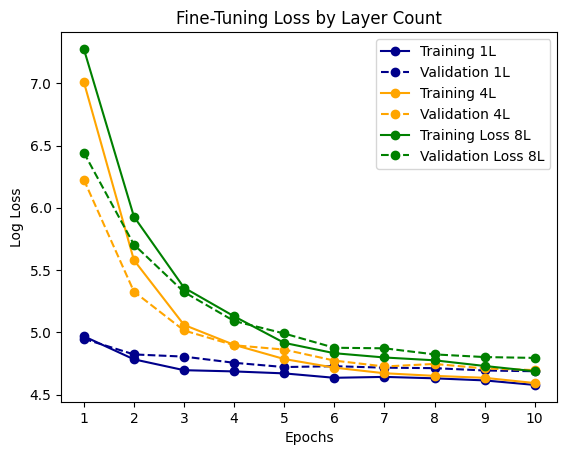

<Figure size 3000x1400 with 0 Axes>

In [ ]:
xs = range(1, 11)

plt.plot(xs, epoch_1l['training'], label='Training 1L', marker='o', color='darkblue')
plt.plot(xs, epoch_1l['validation'], label='Validation 1L', marker='o', ls='dashed', color='darkblue')
#plt.plot(xs, epoch_4l['training'], label='Training 4L', marker='o', color='red')
#plt.plot(xs, epoch_4l['validation'], label='Validation 4L', marker='o', ls='dashed', color='red')
plt.plot(xs, epoch_12l['training'], label='Training 4L', marker='o', color='orange')
plt.plot(xs, epoch_12l['validation'], label='Validation 4L', marker='o', ls='dashed', color='orange')
plt.plot(xs, epoch_8l['training'], label='Training Loss 8L', marker='o', color='green')
plt.plot(xs, epoch_8l['validation'], label='Validation Loss 8L', marker='o', ls='dashed', color='green')

plt.xticks(xs)
plt.title("Fine-Tuning Loss by Layer Count")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.legend()
plt.figure(figsize=(30, 14))

### Test Output

In [ ]:
SYSTEM_PROMPT = """
You are an expert in generating recipe instructions from the recipe title and ingredient list.
""".strip()

PROMPT_HPS = {
  'do_sample': True,
  'temperature': 0.7,
  'top_p': 1.0,
  'max_new_tokens': 256,
  'stop_sequences':None,
  'repetition_penalty': 1.1,
  'use_cache': True
}

def generate_instruction_batch(batch, model=None, tokenizer=None, cot=False, examples=None):

    prompts = [
        f"""{SYSTEM_PROMPT}
Enclose your recipe instructions in <instructions> tags and number each step.
Examples: {examples}
Title: {title}
Ingredients: {ingredients}
Your response:"""
            for title, ingredients in zip(batch['title'], batch['ingredients'])
        ]

    print(prompts[0])

    inputs = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(model.device)

    hps = PROMPT_HPS.copy()

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            **hps,
            pad_token_id=tokenizer.pad_token_id
        )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return {'generated': decoded}#[extract_text(decoded_example, "instructions") for decoded_example in decoded]}

In [ ]:
BATCH_SIZE = 2

small_test = load_from_disk(f'file://{recipe_nlg_data_path}/test_1k')
generated_dataset_oob_TEST = small_test.select([1,2]).map(
    generate_instruction_batch,
    batched=True,
    batch_size=BATCH_SIZE,
    fn_kwargs={"cot": False, "model": model_peft, "tokenizer": tokenizer}
)


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


You are an expert in generating recipe instructions from the recipe title and ingredient list.
Enclose your recipe instructions in <instructions> tags and number each step.
Examples: None
Title: Tarragon Chicken Salad
Ingredients: ["1/4 cup MIRACLE WHIP FREE Dressing", "1/4 tsp. dried tarragon leaves", "3 oz. , cubed", "1 cup red or green grapes, seedless Target 1 lb For $2.99 thru 02/06", "1/2 whole wheat pita bread round", "2 SNACKWELL'S Sugar Free Shortbread Cookies", "4 fl oz (1/2 cup) orange juice"]
Your response:


In [ ]:
print(generated_dataset_oob_TEST['generated'][1])

You are an expert in generating recipe instructions from the recipe title and ingredient list.
Enclose your recipe instructions in <instructions> tags and number each step.
Examples: None
Title: Watercress Tomato Salad
Ingredients: ["8 oz. escarole, torn", "1 bunch watercress", "1 cup cherry tomato halves", "1 cup cucumbers, thinly sliced", "6 tbsp. fat-free Italian dressing", "2 tbsp. crumbled blue cheese", "1 tbsp. fat-free mayonnaise"]
Your response: <instructions>
1. Toss together the escarole, watercress, cherry tomatoes, and cucumber slices in a large bowl. <br>
2. Pour in the Italian dressing, mixing well to evenly coat the salad. <br>
3. Stir in the blue cheese and fat-free mayonnaise. <br>
4. Chill for at least 30 minutes before serving. <br>
</instructions>


In [ ]:
model_peft.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32002, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj):

In [ ]:
generated_dataset_peft_TEST = small_test.select([1,2]).map(
    generate_instruction_batch,
    batched=True,
    batch_size=BATCH_SIZE,
    fn_kwargs={"cot": False, "model": model_peft, "tokenizer": tokenizer}
)


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

You are an expert in generating recipe instructions from the recipe title and ingredient list.
Enclose your recipe instructions in <instructions> tags and number each step.
Examples: None
Title: Tarragon Chicken Salad
Ingredients: ["1/4 cup MIRACLE WHIP FREE Dressing", "1/4 tsp. dried tarragon leaves", "3 oz. , cubed", "1 cup red or green grapes, seedless Target 1 lb For $2.99 thru 02/06", "1/2 whole wheat pita bread round", "2 SNACKWELL'S Sugar Free Shortbread Cookies", "4 fl oz (1/2 cup) orange juice"]
Your response:


### Re-Evaluate and Generate Figures

In [ ]:
|comparison_split = "Prepend your answer to the items in these last 3 lines with [1], [2], and [3] respectively."
reference_free_split = "Prepend your answer to the items in these last 2 lines with [1] and [2] respectively."

def parse_comparison_evaluation(example):

  new_tokens = example['eval_response_comparison_prompt'].split(comparison_split)[-1]
  reference_rating = new_tokens.split("Coherence Rating for Reference (1–10): ")[1].split("\n")[0]
  model_rating = new_tokens.split("Coherence Rating for Model (1–10): ")[1].split("\n")[0]
  try:
    explanation = new_tokens.split("Which is better and why (2–5 sentences):")[1]
  except:
    explanation = "Not Found"

  return {"reference_rating": int(reference_rating), "model_rating": int(model_rating), "explanation": explanation}

def parse_comparison_evaluation(example):

  new_tokens = example['eval_response_comparison_prompt'].split(comparison_split)[-1]
  reference_rating = new_tokens.split("Coherence Rating for Reference (1–10): ")[1].split("\n")[0]
  model_rating = new_tokens.split("Coherence Rating for Model (1–10): ")[1].split("\n")[0]
  try:
    explanation = new_tokens.split("Which is better and why (2–5 sentences):")[1]
  except:
    explanation = "Not Found"

  return {"reference_rating": int(reference_rating), "model_rating": int(model_rating), "explanation": explanation}


def parse_reference_free_evaluation(example):

  new_tokens = example['eval_response_reference_free_prompt'].split(reference_free_split)[-1]
  model_rating = new_tokens.split("Coherence Rating (1–10): ")[1].split("\n")[0]
  try:
    explanation = new_tokens.split("Explanation (2–5 sentences):")[1]
  except:
    explanation = "Not Found"

  return {"model_rating": int(model_rating), "explanation": explanation}

In [ ]:
result_sets = ['Non-Fine-Tuned_Non-Retrieval_0', 'Non-Fine-Tuned_Non-Retrieval_1', 'Non-Fine-Tuned_Non-Retrieval_2', 'Non-Fine-Tuned_Non-Retrieval_3',
               'Non-Fine-Tuned_Retrieval_1', 'Non-Fine-Tuned_Retrieval_2', 'Non-Fine-Tuned_Retrieval_3',
               'Fine-Tuned_Non-Retrieval_0', 'Fine-Tuned_Non-Retrieval_1', 'Fine-Tuned_Non-Retrieval_2', 'Fine-Tuned_Non-Retrieval_3',
               'Fine-Tuned_Retrieval_1', 'Fine-Tuned_Retrieval_2', 'Fine-Tuned_Retrieval_3']

refs = {}
gens = {}
for results in result_sets:
  data = (
      load_from_disk(f'file://{recipe_nlg_data_path}'
                    f'/Generated_Data/Evaluations/{results}')
      .map(parse_comparison_evaluation)
      .to_pandas()
  )

  print(f"Results for {results}")
  refs[results] = data['reference_rating'].mean()
  print(f"Reference: {refs[results]}")
  print(f"Model: {data['model_rating'].mean()}")
  gens[results] = data['model_rating'].mean()

Results for Non-Fine-Tuned_Non-Retrieval_0
Reference: 7.707
Model: 7.414
Results for Non-Fine-Tuned_Non-Retrieval_1
Reference: 8.087
Model: 7.032
Results for Non-Fine-Tuned_Non-Retrieval_2
Reference: 7.982
Model: 7.404
Results for Non-Fine-Tuned_Non-Retrieval_3
Reference: 7.943
Model: 7.532
Results for Non-Fine-Tuned_Retrieval_1
Reference: 8.074
Model: 6.897
Results for Non-Fine-Tuned_Retrieval_2
Reference: 8.013
Model: 7.077
Results for Non-Fine-Tuned_Retrieval_3
Reference: 7.994
Model: 7.16
Results for Fine-Tuned_Non-Retrieval_0
Reference: 8.125
Model: 6.93
Results for Fine-Tuned_Non-Retrieval_1
Reference: 8.031
Model: 7.258
Results for Fine-Tuned_Non-Retrieval_2
Reference: 8.027
Model: 7.22
Results for Fine-Tuned_Non-Retrieval_3
Reference: 8.049
Model: 7.228
Results for Fine-Tuned_Retrieval_1
Reference: 8.085
Model: 6.949
Results for Fine-Tuned_Retrieval_2
Reference: 8.052
Model: 6.84


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Results for Fine-Tuned_Retrieval_3
Reference: 8.074
Model: 6.838


In [ ]:
def get_xs(lst):
  return sorted([3 - i for i, _ in enumerate(lst)])

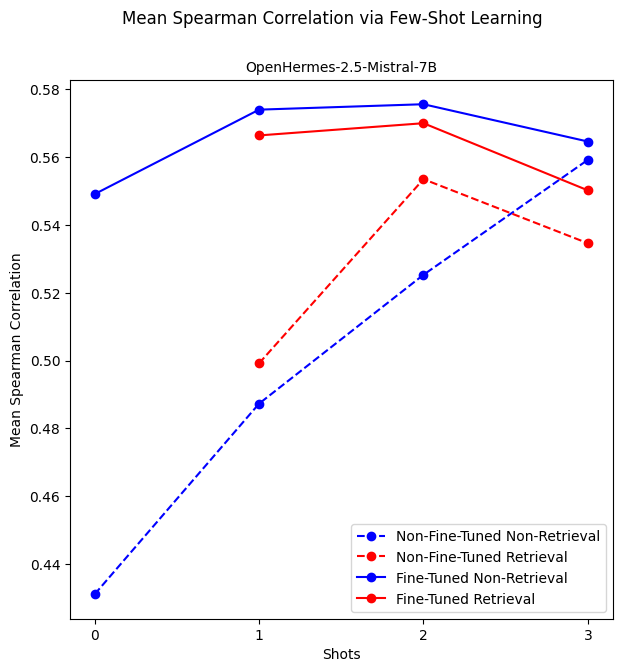

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Reconstitute result sets

nft_nr_s = [val for key, val in sorted(gens.items()) if 'Non-Fine-Tuned_Non-Retrieval' in key]
nft_r_s = [val for key, val in sorted(gens.items()) if 'Non-Fine-Tuned_Retrieval' in key]
ft_nr_s = [val for key, val in sorted(gens.items()) if 'Fine-Tuned_Non-Retrieval' in key]
ft_r_s = [val for key, val in sorted(gens.items()) if 'Fine-Tuned_Retrieval' in key]

ax.plot(get_xs(nft_nr_s), nft_nr_s, label='Non-Fine-Tuned Non-Retrieval', ls='dashed', c='blue', marker='o')
ax.plot(get_xs(nft_r_s), nft_r_s, label='Non-Fine-Tuned Retrieval', ls='dashed', c='red', marker='o')
ax.plot(get_xs(ft_nr_s), ft_nr_s, label='Fine-Tuned Non-Retrieval', c='blue', marker='o')
ax.plot(get_xs(ft_r_s), ft_r_s, label='Fine-Tuned Retrieval', c='red', marker='o')
ax.set_xlabel("Shots")
ax.set_ylabel("Mean Spearman Correlation")
ax.set_xticks(range(4))
fig.set_size_inches(7, 7)
ax.set_title("OpenHermes-2.5-Mistral-7B", fontdict={'fontsize':10})
fig.suptitle("Mean Spearman Correlation via Few-Shot Learning")

ax.legend()

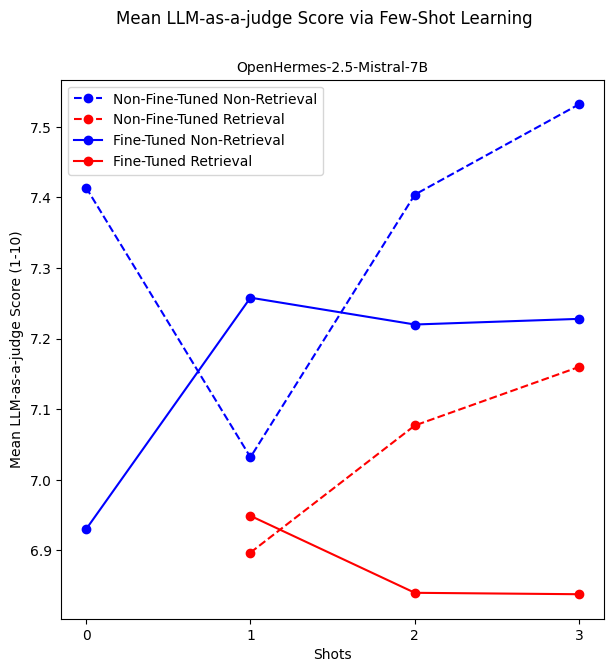

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(get_xs(nft_nr_l), nft_nr_l, label='Non-Fine-Tuned Non-Retrieval', ls='dashed', c='blue', marker='o')
ax.plot(get_xs(nft_r_l), nft_r_l, label='Non-Fine-Tuned Retrieval', ls='dashed', c='red', marker='o')
ax.plot(get_xs(ft_nr_l), ft_nr_l, label='Fine-Tuned Non-Retrieval', c='blue', marker='o')
ax.plot(get_xs(ft_r_l), ft_r_l, label='Fine-Tuned Retrieval', c='red', marker='o')
ax.set_xlabel("Shots")
ax.set_ylabel("Mean LLM-as-a-judge Score (1-10)")
ax.set_xticks(range(4))
ax.set_title("OpenHermes-2.5-Mistral-7B", fontdict={'fontsize':10})
fig.suptitle("Mean LLM-as-a-judge Score via Few-Shot Learning")
fig.set_size_inches(7, 7)
ax.legend(loc='best')

### Montonic Sequence Error Analysis

In [ ]:
from itertools import combinations_with_replacement
from scipy.stats import spearmanr

In [ ]:
def generate_monotonic_lists(n):
    """
    Generate all monotonic non-decreasing lists of length n
    using integers from 1 to n inclusive.
    """
    return list(combinations_with_replacement(range(1, n + 1), n))


In [ ]:
#spearmans = []

xs = range(2, 11)
xs = range(11, 18)

for i in xs:
  print(i)
  base = list(range(1, i+1))
  lists = generate_monotonic_lists(i)
  spearman = [spearmanr(base, sublist).statistic for sublist in lists]
  spearmans.append([a for a in spearman if a > -1000])

11


/tmp/ipython-input-52942081.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman = [spearmanr(base, sublist).statistic for sublist in lists]


12
13
14


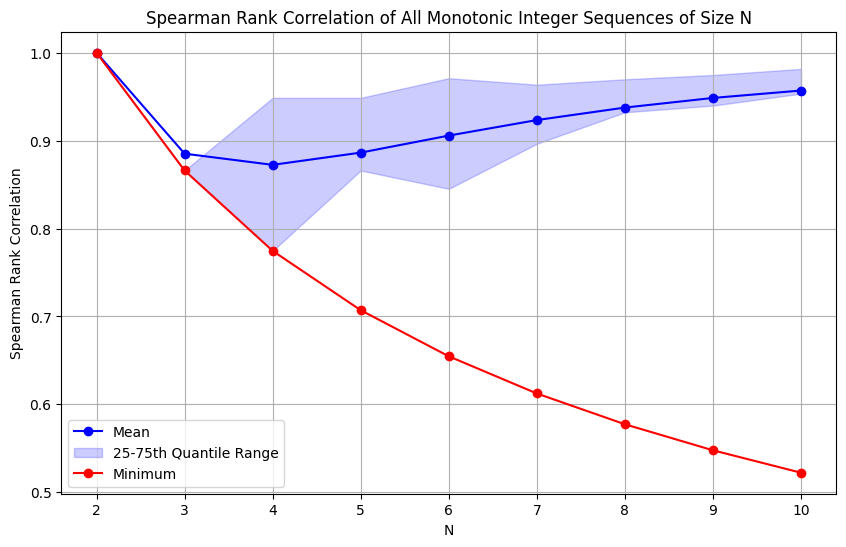

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example: simulate data for 9 groups (group IDs 2 to 10)
np.random.seed(42)
groups = range(2, 18)
data = {group: spearmans[group-2] for group in groups}

# Calculate statistics
means = []
q_low = []
q_high = []

for group in groups:
    values = data[group]
    means.append(np.mean(values))
    q_low.append(np.quantile(values, 0.25))   # 25th percentile
    q_high.append(np.quantile(values, 0.75))  # 75th percentile

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(groups, means, label='Mean', color='blue', marker='o')
plt.fill_between(groups, q_low, q_high, color='blue', alpha=0.2, label='25-75th Quantile Range')
plt.plot(groups, [np.min(values) for values in data.values()], label='Minimum', color='red', marker='o')

plt.xlabel('N')
plt.ylabel('Spearman Rank Correlation')
plt.title('Spearman Rank Correlation of All Monotonic Integer Sequences of Size N')
plt.legend()
plt.grid(True)
plt.show()
